# Decision Dependent Games Simulation
## Uber vs. Lyft

We introduce fictional performative effects on top of real data scraped from Uber and Lyft to simulate a decision dependent risk minimization game.

In [1]:
import math
import numpy as np
import pandas as pd
import sys
import datetime

sys.path.append("../utils/")
from utils_rideshare import *

from dd_game_rideshare import *
from two_stage_player_rideshare import *
from dfo_player_rideshare import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set_style('darkgrid')

from tqdm import tqdm, trange
tqdm.pandas()

C:\Users\evanj\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
rides = pd.read_csv('../data/rideshare_kaggle.csv')
rides['date'] = rides.progress_apply(lambda row: datetime.datetime.strptime(row['datetime'], '%Y-%m-%d %H:%M:%S').date(), axis=1)

new_rides = rides[['hour','cab_type','price','distance','date']].dropna(subset = ['price']).reset_index()
new_rides['distance'] = new_rides.progress_apply(lambda row: math.ceil(row['distance']), axis=1)
new_rides['price'] = new_rides.progress_apply(lambda row: 5*math.floor(row['price']/5), axis=1)

cab_types_ = new_rides.cab_type.unique()
distances_ = new_rides.distance.unique()
hours_ = np.array([17,18,19])  # new_rides.hour.unique()
prices_ = np.array([10, 15])# np.array([5*(i) for i in range(5)])  # new_rides.price.unique()
dates = len(new_rides.date.unique())

g = np.zeros((len(cab_types_),len(prices_),len(hours_),len(distances_)))

for i in range(len(cab_types_)):
    for j in trange(len(prices_)):
        for k in range(len(hours_)):
            for m in range(len(distances_)):
                g[i,j,k,m] = len(new_rides[(new_rides['cab_type']==cab_types_[i])
                                          &(new_rides['price']==prices_[j])
                                          &(new_rides['hour']==hours_[k])
                                          &(new_rides['distance']==distances_[m])])/dates

np.random.seed(37)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.13it/s]


# Configurations

In [3]:
x = [17,2]  # [time, distance]
g_uber = g[np.where(cab_types_=='Uber'),:,np.where(hours_==x[0]),np.where(distances_==x[1])].reshape((-1,1))
g_lyft = g[np.where(cab_types_=='Lyft'),:,np.where(hours_==x[0]),np.where(distances_==x[1])].reshape((-1,1))

prices_ = prices_.reshape((-1,1))

print(f'g_uber = \n{g_uber}')
print(f'g_lyft = \n{g_lyft}')

d_1 = len(g_uber)  # Dimension of each player's data/strategy
d_2 = len(g_lyft)

lambda_p1 = 1
lambda_p2 = 1

eta_p1 = 1e-3
eta_p2 = 1e-3

mu_p1 = -0.07*g_uber
gamma_p1 = 0.03*g_uber
mu_p2 = -0.07*g_lyft
gamma_p2 = 0.03*g_lyft

g_uber = 
[[52.11764706]
 [51.11764706]]
g_lyft = 
[[76.64705882]
 [54.11764706]]


In [4]:
p1_data_params = (g_uber, d_1, mu_p1, gamma_p1, lambda_p1, eta_p1, prices_)
p1_data_generating_func = sample_from_location_family_rideshare

p2_data_params = (g_lyft, d_2, mu_p2, gamma_p2, lambda_p2, eta_p2, prices_)
p2_data_generating_func = sample_from_location_family_rideshare

In [5]:
num_rounds_lst = np.logspace(2,5,10,dtype='int')
num_test = 10000
num_alternate_rounds = 1000

# Run game with 2-stage algorithm

In [6]:
p1_risks = []
p2_risks = []
theta_final_p1 = []
theta_final_p2 = []

for num_rounds in num_rounds_lst:
    print(f"num_rounds = {num_rounds}")
    player_one = TwoStagePlayer()
    player_two = TwoStagePlayer()
    game_ts = DecisionDependentGame(player_one, player_two,
                                    p1_data_params, p2_data_params,
                                    p1_data_generating_func, p2_data_generating_func,
                                    num_rounds, num_alternate_rounds, num_test)
    
    game_ts.run_train()
    game_ts.run_post_train_alternating()
    
    PR1 = game_ts.evaluate_perf_risk_p1()
    PR2 = game_ts.evaluate_perf_risk_p2()
    
    p1_risks.append(PR1)
    p2_risks.append(PR2)
    
    theta_final_p1.append(game_ts.theta_p1)
    theta_final_p2.append(game_ts.theta_p2)
    
    #Change this flag if one wants to change print settings
    if True:
        print("---------------------")
        print("Player 1: mu error")
        print(np.linalg.norm(mu_p1-player_one.mu_hat))
        print("Player 1: gamma error")
        print(np.linalg.norm(gamma_p1-player_one.gamma_hat))
        print("Player 1 Risk:")
        print(PR1)

        print("Player 2: mu error")
        print(np.linalg.norm(mu_p2-player_two.mu_hat))
        print("Player 2: gamma error")
        print(np.linalg.norm(gamma_p2-player_two.gamma_hat))
        print("Player 2 Risk:")
        print(PR2)
        print("---------------------")

num_rounds = 100
---------------------
Player 1: mu error
2.4683877131553618
Player 1: gamma error
1.7476324803160848
Player 1 Risk:
-1287.2109693490881
Player 2: mu error
0.9042583813235932
Player 2: gamma error
0.6254605072629866
Player 2 Risk:
-1596.2029203762877
---------------------
num_rounds = 215
---------------------
Player 1: mu error
1.8103063201940954
Player 1: gamma error
0.5921566482918065
Player 1 Risk:
-1252.171042649247
Player 2: mu error
0.7359623068845628
Player 2: gamma error
0.7437428166616028
Player 2 Risk:
-1707.8358823299893
---------------------
num_rounds = 464
---------------------
Player 1: mu error
0.9419561097459389
Player 1: gamma error
0.5441962135961547
Player 1 Risk:
-1317.305421691065
Player 2: mu error
0.5810400625863357
Player 2: gamma error
0.28777469249805887
Player 2 Risk:
-1719.8494432145749
---------------------
num_rounds = 1000
---------------------
Player 1: mu error
0.3194986715700569
Player 1: gamma error
0.8656713211821105
Player 1 Risk:


# Run game with DFO players

In [64]:
p3_risks = []
p4_risks = []
theta_final_p3 = []
theta_final_p4 = []

delta = 1e-2
eta = 1e-1
num_test_dfo = 50
num_rounds = num_rounds_lst[-1]
batch_size = 5

player_three = DFOPlayer(delta,eta)
player_four = DFOPlayer(delta,eta)
game_dfo = DecisionDependentGame(player_three, player_four,
                                 p1_data_params, p2_data_params,
                                 p1_data_generating_func, p2_data_generating_func,
                                 num_test_dfo)

for i in trange(math.ceil(num_rounds/batch_size/num_test_dfo)+1):
    PR_3_oracle = []
    PR_4_oracle = []
    for j in range(batch_size):
        game_dfo.theta_p1 = player_three.perturb_theta()
        game_dfo.theta_p2 = player_four.perturb_theta()

        PR_3_oracle.append(game_dfo.evaluate_perf_risk_p1())
        PR_4_oracle.append(game_dfo.evaluate_perf_risk_p2())
    
    game_dfo.theta_p1 = player_three.update_theta(PR_3_oracle)
    game_dfo.theta_p2 = player_four.update_theta(PR_4_oracle)
    
    if i*batch_size*num_test_dfo >= num_rounds_lst[len(p3_risks)]:
        p3_risks.append(evaluate_performative_risk(p1_data_generating_func, g_uber, prices_,
                                                   mu_p1, gamma_p1,
                                                   lambda_p1,
                                                   game_dfo.theta_p1, game_dfo.theta_p2,
                                                   num_test))
        p4_risks.append(evaluate_performative_risk(p2_data_generating_func, g_lyft, prices_,
                                                   mu_p2, gamma_p2,
                                                   lambda_p2,
                                                   game_dfo.theta_p2, game_dfo.theta_p1,
                                                   num_test))
        
        theta_final_p3.append(game_dfo.theta_p1)
        theta_final_p4.append(game_dfo.theta_p2)
    
        if True:
            print("---------------------")
            print(f"Iteration {i}")
            print("Player 3 risk:")
            print(p3_risks[-1])

            print("Player 4 risk:")
            print(p4_risks[-1])
            print("---------------------")
            
# print(np.mean(game_dfo.p1.theta_history))
# print(np.mean(game_dfo.p2.theta_history))
# theta_final_p3[-1] = np.mean(game_dfo.p1.theta_history)
# theta_final_p4[-1] = np.mean(game_dfo.p2.theta_history)

  7%|█████▍                                                                          | 27/401 [00:00<00:01, 251.19it/s]

---------------------
Iteration 1
Player 3 risk:
-1289.8989706746154
Player 4 risk:
-1575.5282199236474
---------------------
---------------------
Iteration 2
Player 3 risk:
-1290.8883415207042
Player 4 risk:
-1578.397226394028
---------------------
---------------------
Iteration 3
Player 3 risk:
-1294.062170621035
Player 4 risk:
-1579.6309777989247
---------------------
---------------------
Iteration 4
Player 3 risk:
-1294.555343808126
Player 4 risk:
-1572.5766450114816
---------------------
---------------------
Iteration 9
Player 3 risk:
-1284.3010931434496
Player 4 risk:
-1571.4018179533693
---------------------
---------------------
Iteration 19
Player 3 risk:
-1281.4549663403643
Player 4 risk:
-1574.6387774489242
---------------------
---------------------
Iteration 40
Player 3 risk:
-1282.7023485974003
Player 4 risk:
-1580.6306886094142
---------------------


 37%|████████████████████████████▉                                                  | 147/401 [00:00<00:00, 324.91it/s]

---------------------
Iteration 87
Player 3 risk:
-1287.7531488276313
Player 4 risk:
-1578.998259936156
---------------------


 60%|███████████████████████████████████████████████▍                               | 241/401 [00:00<00:00, 375.19it/s]

---------------------
Iteration 186
Player 3 risk:
-1283.167494306568
Player 4 risk:
-1576.9281399900249
---------------------


100%|███████████████████████████████████████████████████████████████████████████████| 401/401 [00:00<00:00, 409.65it/s]

---------------------
Iteration 400
Player 3 risk:
-1285.257333982879
Player 4 risk:
-1574.0183997304448
---------------------


## Plots

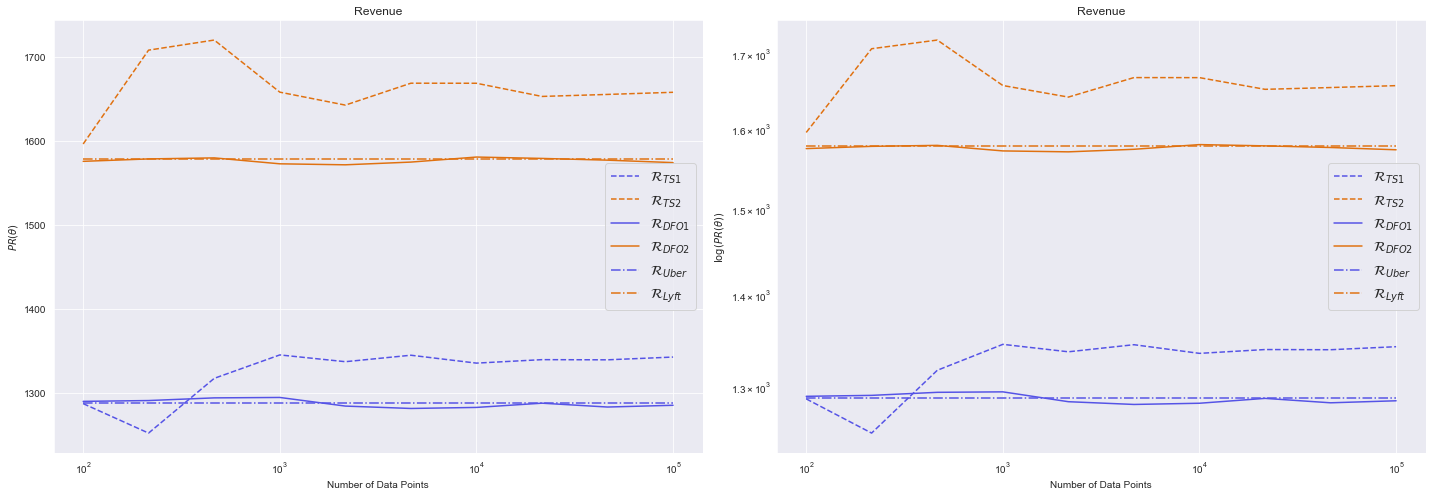

In [65]:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.semilogx(num_rounds_lst, -np.squeeze(p1_risks),
             '--', color='#5553E6', label=r'$\mathcal{R}_{TS1}$')
plt.semilogx(num_rounds_lst, -np.squeeze(p2_risks),
             '--', color='#E07110', label=r'$\mathcal{R}_{TS2}$')

plt.semilogx(num_rounds_lst, -np.squeeze(p3_risks),
             '-', color='#5553E6', label=r'$\mathcal{R}_{DFO1}$')
plt.semilogx(num_rounds_lst, -np.squeeze(p4_risks),
             '-', color='#E07110', label=r'$\mathcal{R}_{DFO2}$')

plt.semilogx(num_rounds_lst, [np.dot(g_uber.T,prices_)[0,0] for i in range(len(num_rounds_lst))],
             '-.', color='#5553E6', label=r'$\mathcal{R}_{Uber}$')
plt.semilogx(num_rounds_lst, [np.dot(g_lyft.T,prices_)[0,0] for i in range(len(num_rounds_lst))],
             '-.', color='#E07110', label=r'$\mathcal{R}_{Lyft}$')

plt.xlabel("Number of Data Points")
plt.ylabel(r"$PR(\theta)$")
plt.title("Revenue")
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.loglog(num_rounds_lst, -np.squeeze(p1_risks),
           '--', color='#5553E6', label=r'$\mathcal{R}_{TS1}$')
plt.loglog(num_rounds_lst, -np.squeeze(p2_risks),
           '--', color='#E07110', label=r'$\mathcal{R}_{TS2}$')

plt.loglog(num_rounds_lst, -np.squeeze(p3_risks),
             '-', color='#5553E6', label=r'$\mathcal{R}_{DFO1}$')
plt.loglog(num_rounds_lst, -np.squeeze(p4_risks),
             '-', color='#E07110', label=r'$\mathcal{R}_{DFO2}$')

plt.loglog(num_rounds_lst, [np.dot(g_uber.T,prices_)[0,0] for i in range(len(num_rounds_lst))],
             '-.', color='#5553E6', label=r'$\mathcal{R}_{Uber}$')
plt.loglog(num_rounds_lst, [np.dot(g_lyft.T,prices_)[0,0] for i in range(len(num_rounds_lst))],
             '-.', color='#E07110', label=r'$\mathcal{R}_{Lyft}$')

plt.xlabel("Number of Data Points")
plt.ylabel(r"$\log(PR(\theta))$")
plt.title('Revenue')
plt.legend(fontsize=14)

# plt.subplot(1,3,3)
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p1),
#            '--', color='#5553E6', label=r'$\theta_{TS1}$')
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p2),
#            '--', color='#E07110', label=r'$\theta_{TS2}$')

# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p3),
#            '-', color='#5553E6', label=r'$\theta_{DFO1}$')
# plt.semilogx(num_rounds_lst, np.squeeze(theta_final_p4),
#            '-', color='#E07110', label=r'$\theta_{DFO2}$')

# plt.ylim(-10,10)
# plt.xlabel("Number of Data Points")
# plt.ylabel(r"$\log(PR(\theta))$")
# plt.title('Strategies')
# plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('DD_regression_rideshare_convergence.jpg', format='jpg')
plt.show()

In [66]:
print(f'theta_1_ts - theta_1_dfo = \n{game_ts.theta_p1-game_dfo.theta_p1}')
print(f'theta_2_ts - theta_2_dfo = \n{game_ts.theta_p2-game_dfo.theta_p2}')

theta_1_ts - theta_1_dfo = 
[[ 2.26260211]
 [-0.17985524]]
theta_2_ts - theta_2_dfo = 
[[ 2.1758982]
 [-0.1811752]]


In [67]:
print(f'theta_1_ts = \n{game_ts.theta_p1}')
print(f'theta_2_ts = \n{game_ts.theta_p2}')

theta_1_ts = 
[[ 2.09493197]
 [-0.25727214]]
theta_2_ts = 
[[ 2.28417054]
 [-0.23741013]]


In [68]:
print(f'theta_1_dfo = \n{game_dfo.theta_p1}')
print(f'theta_2_dfo = \n{game_dfo.theta_p2}')

theta_1_dfo = 
[[-0.16767013]
 [-0.0774169 ]]
theta_2_dfo = 
[[ 0.10827234]
 [-0.05623493]]


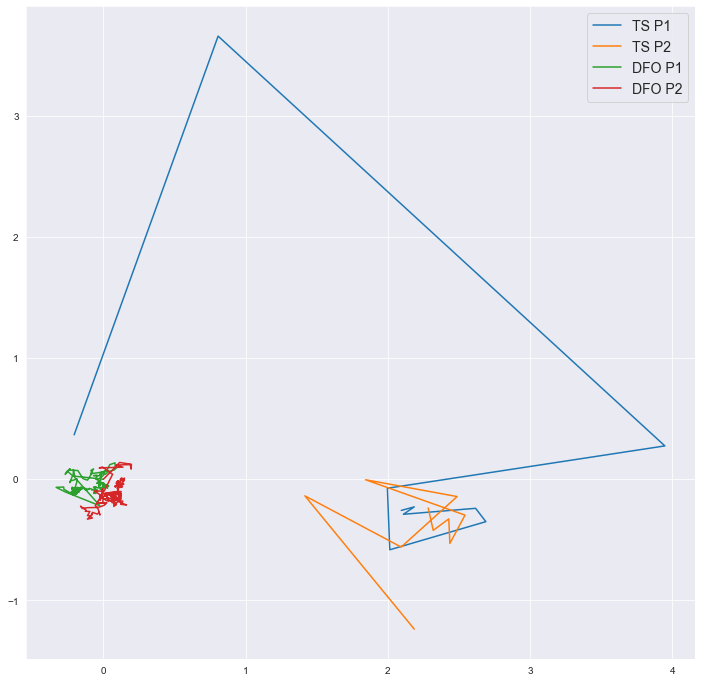

In [69]:
plt.figure(figsize=(12,12))
plt.plot(np.array(theta_final_p1)[:,0].squeeze(),
         np.array(theta_final_p1)[:,1].squeeze(), label='TS P1')
plt.plot(np.array(theta_final_p2)[:,0].squeeze(),
         np.array(theta_final_p2)[:,1].squeeze(), label='TS P2')
plt.plot(np.array(game_dfo.p1.theta_history)[:,0].squeeze(),
         np.array(game_dfo.p1.theta_history)[:,1].squeeze(), label='DFO P1')
plt.plot(np.array(game_dfo.p2.theta_history)[:,0].squeeze(),
         np.array(game_dfo.p2.theta_history)[:,1].squeeze(), label='DFO P2')
plt.legend(fontsize=14)
plt.savefig('DD_regression_rideshare_trajectory.jpg', format='jpg')
plt.show()

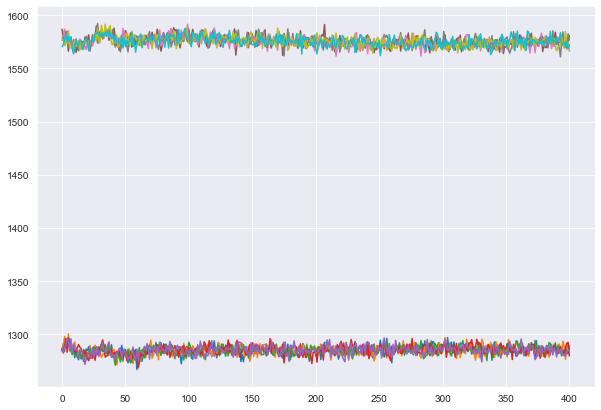

In [70]:
plt.figure(figsize=(10,7))
plt.plot(-np.squeeze(game_dfo.p1.risk_history))
plt.plot(-np.squeeze(game_dfo.p2.risk_history))
plt.show()

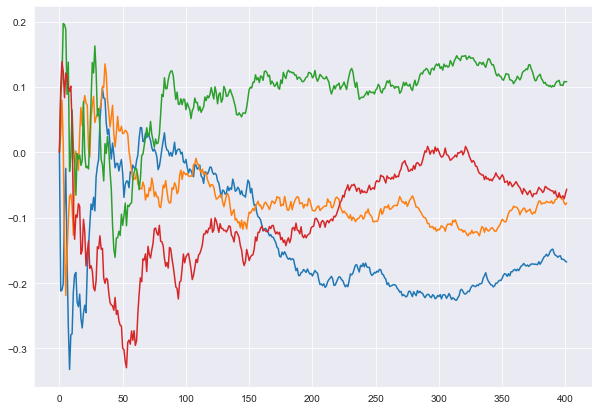

In [71]:
plt.figure(figsize=(10,7))
plt.plot(np.squeeze(game_dfo.p1.theta_history))
plt.plot(np.squeeze(game_dfo.p2.theta_history))
plt.show()